In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import time
import os
import re
import itertools
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import autocast
from torch.cuda.amp import GradScaler
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import MinMaxScaler


import optuna

from NF_condGLOW import *

2024-04-15 16:13:15.846904: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 16:13:16.440070: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 16:13:18.275330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = pd.read_parquet('/export/home/vgiusepp/MW_MH/data/preprocessing/preprocess_training_set_Galaxy_name.parquet')
Galax_name = data['Galaxy_name'].unique()
Galaxy_to_study = np.random.choice(Galax_name, 5)
data = data[data['Galaxy_name'].isin(Galaxy_to_study)]
for galaxy in Galaxy_to_study:
    print(galaxy, 'Log10 Number of stars:', np.log10(len(data[data['Galaxy_name'] == galaxy])))
print('Total Log10 Number of stars:', np.log10(len(data)))

g2.83e10.00944 Log10 Number of stars: 4.145600357652248
g2.94e10.00768 Log10 Number of stars: 4.913151312999839
g8.63e09.00784 Log10 Number of stars: 3.2528530309798933
g1.57e11.00176 Log10 Number of stars: 4.085290578230065
g4.99e10.00912 Log10 Number of stars: 4.780245283865352
Total Log10 Number of stars: 5.230724738504728


In [2]:
data = pd.read_parquet('/export/home/vgiusepp/MW_MH/data/preprocessing/preprocess_training_set_Galaxy_name.parquet').iloc[:100_001]
Galaxy_to_study = data['Galaxy_name'].unique()
print(Galaxy_to_study)

['g1.05e11.00080' 'g1.05e11.00096' 'g1.05e11.00112' 'g1.05e11.00128'
 'g1.05e11.00144' 'g1.05e11.00160' 'g1.05e11.00176' 'g1.05e11.00192'
 'g1.05e11.00208' 'g1.05e11.00224' 'g1.05e11.00240' 'g1.05e11.00256'
 'g1.05e11.00272' 'g1.05e11.00288']


In [3]:
cond_names = list(data.keys()[2:-1])
device = torch.device("cuda:9" if torch.cuda.is_available() else "cpu")

Flow = NF_condGLOW(n_layers=6, dim_notcond=2, dim_cond=12, CL=NSF_CL2, network_args=[128*2, 6, 0.2]).to(device=device)

#losses = []
#training_flow(flow = Flow, 
#                data = data, 
#                cond_names=cond_names, 
#                epochs=20, lr=10**-4, batch_size=1024, 
#                loss_saver=losses, checkpoint_dir='/export/home/vgiusepp/MW_MH/tests/architecture/checkpoints/checkpoint_data/', gamma=0.998, optimizer_obj=None)
#Flow.load_state_dict(torch.load('../architecture/checkpoints/checkpoint_data/checkpoint_best.pth'))
Flow.load_state_dict(torch.load('/export/home/vgiusepp/MW_MH/tests/architecture/distributed/checkpoint.pt'))

<All keys matched successfully>

In [4]:
feh_mean, feh_std = np.load('../../data/preprocessing/mean_std_of_feh.npz')['mean'], np.load('../../data/preprocessing/mean_std_of_feh.npz')['std']
ofe_mean, ofe_std = np.load('../../data/preprocessing/mean_std_of_ofe.npz')['mean'], np.load('../../data/preprocessing/mean_std_of_ofe.npz')['std']

data['feh'], data['ofe'] = (data['feh']*feh_std + feh_mean), (data['ofe']*ofe_std + ofe_mean)


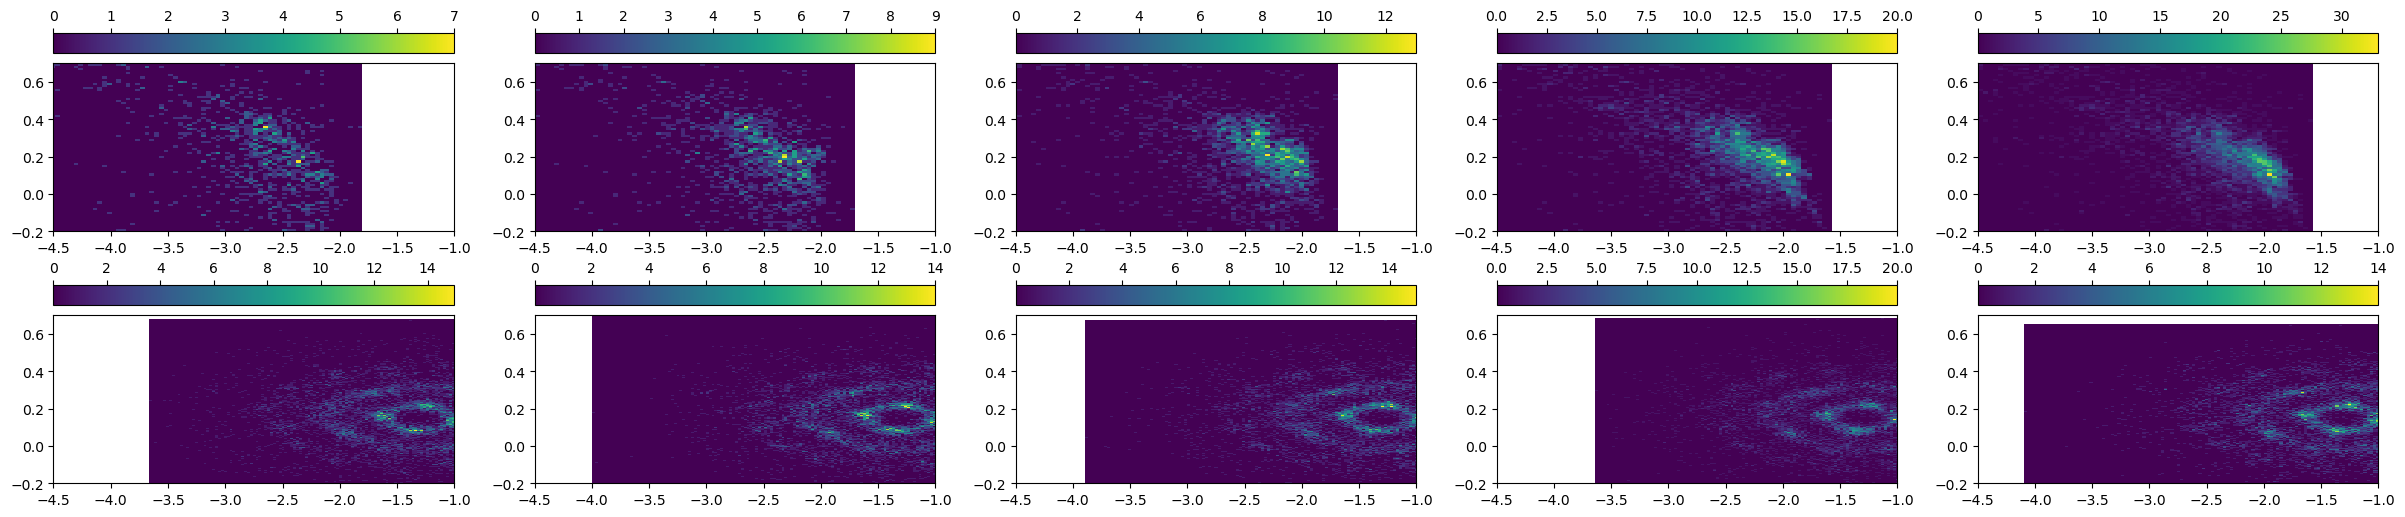

In [5]:
fig = plt.figure(figsize=(30, 6))
bad_column = ['Galaxy_name']
other_columns = data.columns.difference(bad_column, sort=False)

i=0
for galaxy in Galaxy_to_study[:5]:
    i+=1
    ax = fig.add_subplot(2,5,i)
    cax = ax.hist2d(data[data['Galaxy_name']==galaxy]['feh'], data[data['Galaxy_name']==galaxy]['ofe'],
                    bins=100);
    fig.colorbar(cax[3], ax=ax, location='top')
    ax.set_xlim(-4.5, -1.0)
    ax.set_ylim(-0.2, 0.7)
    
    samples = Flow.sample_Flow(10000, data[(data['Galaxy_name']==galaxy)][other_columns].values[0, 2:]).cpu().detach()
    ax = fig.add_subplot(2, 5, i+5)
    cax = ax.hist2d(samples[:, 0], samples[:, 1], bins=200);
    ax.set_xlim(-4.5, -1.0)
    ax.set_ylim(-0.2, 0.7)
    fig.colorbar(cax[3], ax=ax, location='top')

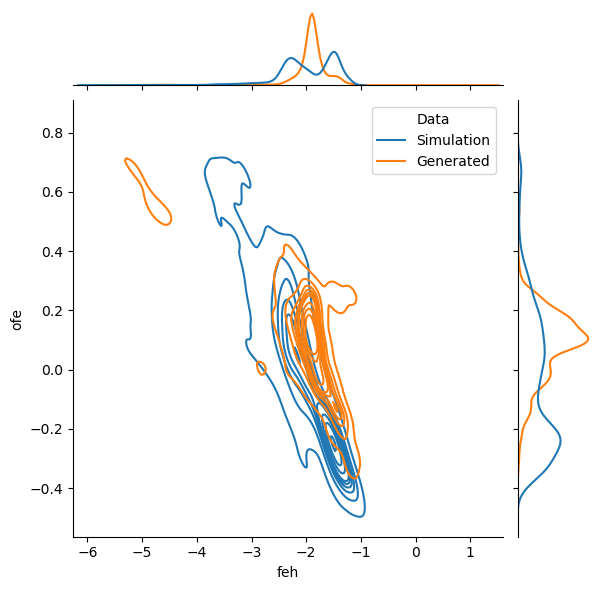

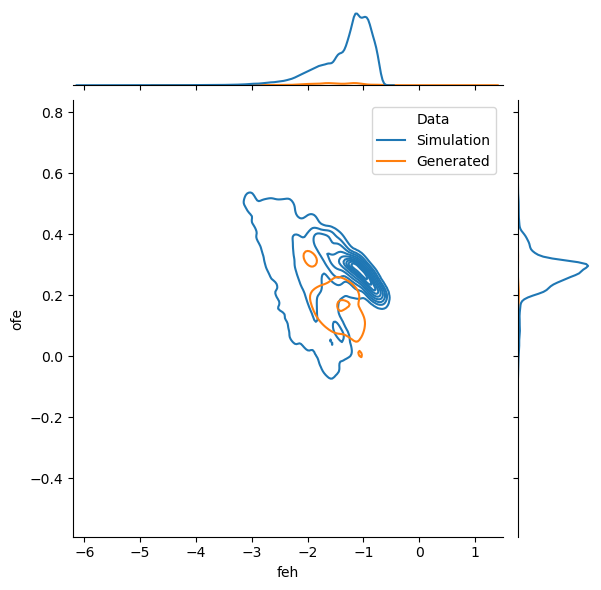

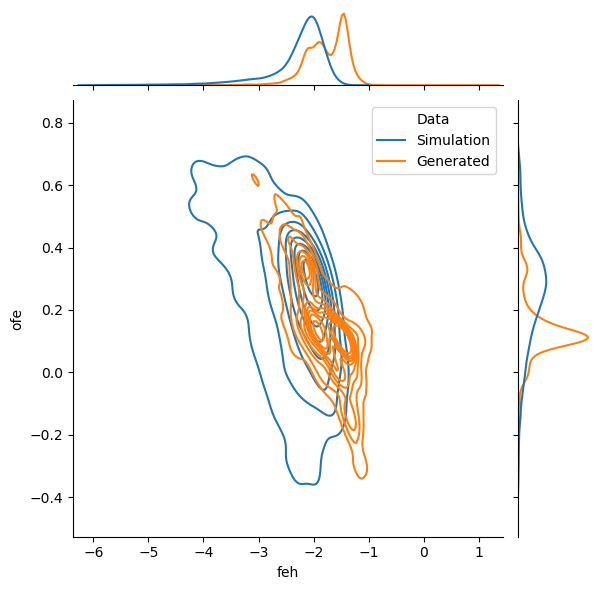

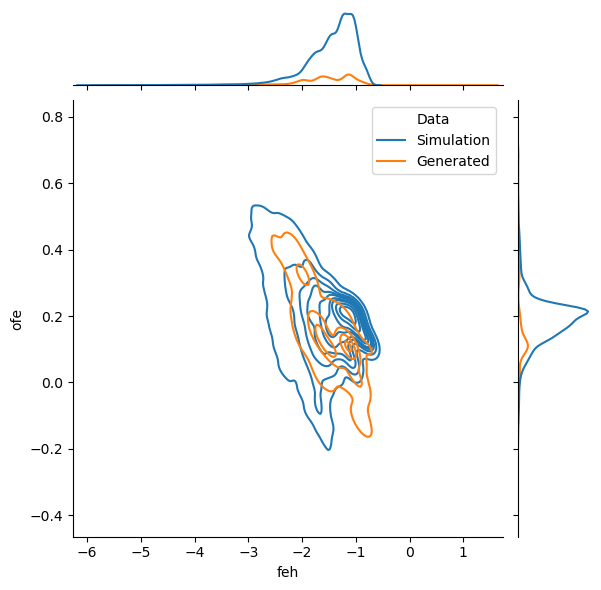

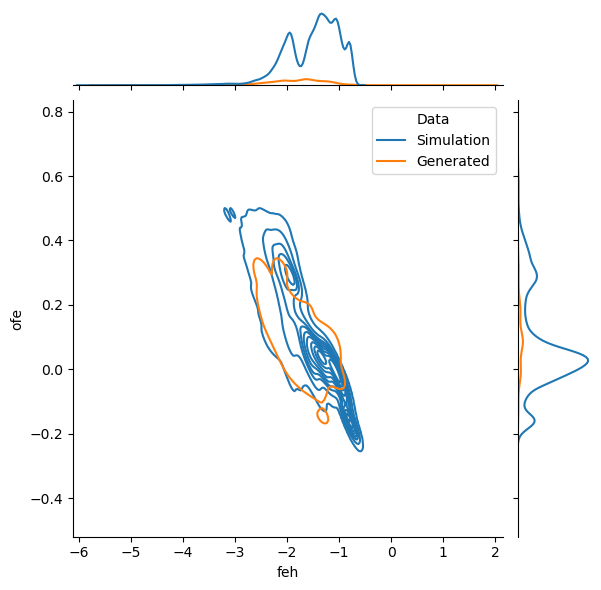

In [ ]:
for galaxy in Galaxy_to_study[:5]:
    
    true_data = data[data['Galaxy_name']==galaxy]
    generated_data = Flow.sample_Flow(10000, data[data['Galaxy_name']==galaxy][other_columns].values[0,2:]).cpu().detach()
    generated_data = pd.DataFrame(generated_data.numpy(), columns=['feh', 'ofe'])
    
    true_data = true_data[['feh', 'ofe']]
    true_data['Data'] = 'Simulation'
    generated_data['Data'] = 'Generated'
    
    df_joinplot = pd.concat([true_data, generated_data])
    sns.jointplot(data=df_joinplot, x='feh', y='ofe', hue='Data', kind='kde')
    